In [1]:
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

#loading creating and saving the datasets

In [4]:
# def load_celeb_data(loading_method):
#     if loading_method == 'colab':
#         data_dir = '/content/drive/My Drive/celebs/data'  # Update the path accordingly
#     elif loading_method == 'direct':
#         data_dir = 'data'  # Update the path accordingly

#     class_folders = sorted(os.listdir(data_dir))  # Sorting folders
#     classes = {cls: i for i, cls in enumerate(class_folders)}

#     imgs = []
#     labels = []
#     for i, cls_folder in enumerate(class_folders):  # Enumerate through folders
#         cls_path = os.path.join(data_dir, cls_folder)
#         images_path = [elt for elt in os.listdir(cls_path) if elt.find('.jpg') > 0]
#         label = i  # Assigning label based on folder order
#         for img in tqdm(images_path[:300]):
#             path = os.path.join(cls_path, img)
#             if os.path.exists(path):
#                 image = Image.open(path)
#                 image = image.resize((150, 150))
#                 imgs.append(np.array(image))
#                 labels.append(label)

#     X = np.array(imgs)
#     num_classes = len(class_folders)
#     y = to_categorical(labels, num_classes=num_classes)

#     # Shuffle the data
#     p = np.random.permutation(len(X))
#     X, y = X[p], y[p]

#     # Split the data into train, validation, and test sets
#     first_split = int(len(imgs) / 6.)
#     second_split = first_split + int(len(imgs) * 0.2)
#     X_test, X_val, X_train = X[:first_split], X[first_split:second_split], X[second_split:]
#     y_test, y_val, y_train = y[:first_split], y[first_split:second_split], y[second_split:]

#     return X_train, y_train, X_val, y_val, X_test, y_test, num_classes

# # Load data
# X_train, y_train, X_val, y_val, X_test, y_test, num_classes = load_celeb_data('colab')

In [5]:
# save_dir = '/content/drive/My Drive/celebs/'
# os.makedirs(save_dir, exist_ok=True)
# np.save(os.path.join(save_dir, 'X_train.npy'), X_train)
# np.save(os.path.join(save_dir, 'y_train.npy'), y_train)
# np.save(os.path.join(save_dir, 'X_val.npy'), X_val)
# np.save(os.path.join(save_dir, 'y_val.npy'), y_val)
# np.save(os.path.join(save_dir, 'X_test.npy'), X_test)
# np.save(os.path.join(save_dir, 'y_test.npy'), y_test)
# np.save(os.path.join(save_dir, 'num_classes.npy'), num_classes)

In [6]:
#take the npy because if load the images crash with the 12 gb
save_dir = '/content/drive/My Drive/celebs/'
X_train = np.load(os.path.join(save_dir, 'X_train.npy'))
y_train = np.load(os.path.join(save_dir, 'y_train.npy'))
X_val = np.load(os.path.join(save_dir, 'X_val.npy'))
y_val = np.load(os.path.join(save_dir, 'y_val.npy'))
X_test = np.load(os.path.join(save_dir, 'X_test.npy'))
y_test = np.load(os.path.join(save_dir, 'y_test.npy'))
num_classes = np.load(os.path.join(save_dir, 'num_classes.npy'))

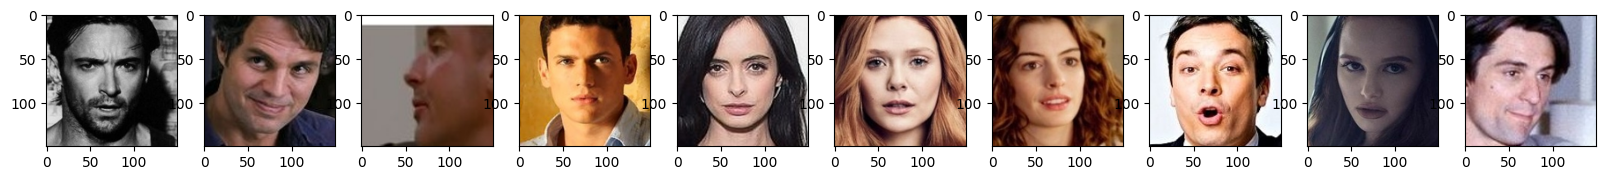

In [7]:
plt.figure(figsize=(20,15))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(X_train[i])

In [8]:
# Data preprocessing
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [9]:
def build_model(fine_tune_at):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    base_model.trainable = True

    # Fine-tune from this layer onwards
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),  # Additional Dense layer
        layers.Dropout(0.3),                   # Additional Dropout layer
        layers.Dense(64, activation='relu'),   # Additional Dense layer
        layers.Dropout(0.2),                   # Additional Dropout layer
        layers.Dense(32, activation='relu'),   # Additional Dense layer
        layers.Dropout(0.1),                   # Additional Dropout layer
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=optimizers.Adam(learning_rate=0.000055),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model



In [13]:
# Callbacks
es = callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True)
lr_reducer = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3, verbose=1, min_lr=1e-10)
model_checkpoint = callbacks.ModelCheckpoint("/content/drive/My Drive/celebs/model.h5", monitor="val_loss", verbose=1, save_best_only=True)

# Model training
model = build_model(fine_tune_at=10)
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=50,
                    callbacks=[es, lr_reducer, model_checkpoint])



Epoch 1/100
223/223 [==============================] - ETA: 0s - loss: 4.6603 - accuracy: 0.0092
Epoch 1: val_loss improved from inf to 4.65100, saving model to /content/drive/My Drive/celebs/model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


223/223 [==============================] - 18s 48ms/step - loss: 4.6603 - accuracy: 0.0092 - val_loss: 4.6510 - val_accuracy: 0.0177 - lr: 5.5000e-05
Epoch 2/100
221/223 [============================>.] - ETA: 0s - loss: 4.6533 - accuracy: 0.0136
Epoch 2: val_loss did not improve from 4.65100
223/223 [==============================] - 6s 27ms/step - loss: 4.6533 - accuracy: 0.0135 - val_loss: 4.6514 - val_accuracy: 0.0157 - lr: 5.5000e-05
Epoch 3/100
223/223 [==============================] - ETA: 0s - loss: 4.6502 - accuracy: 0.0115
Epoch 3: val_loss improved from 4.65100 to 4.64444, saving model to /content/drive/My Drive/celebs/model.h5
223/223 [==============================] - 7s 30ms/step - loss: 4.6502 - accuracy: 0.0115 - val_loss: 4.6444 - val_accuracy: 0.0208 - lr: 5.5000e-05
Epoch 4/100
221/223 [============================>.] - ETA: 0s - loss: 4.6264 - accuracy: 0.0148
Epoch 4: val_loss improved from 4.64444 to 4.57268, saving model to /content/drive/My Drive/celebs/model.h

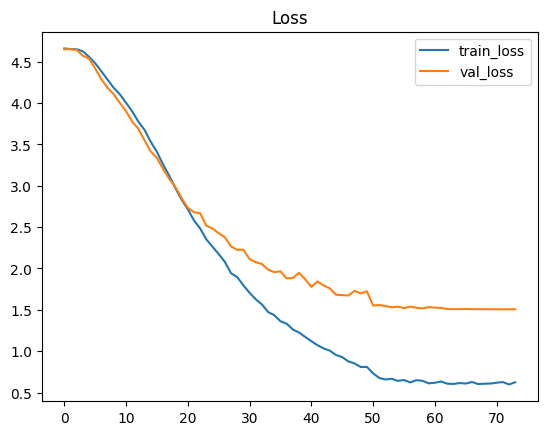

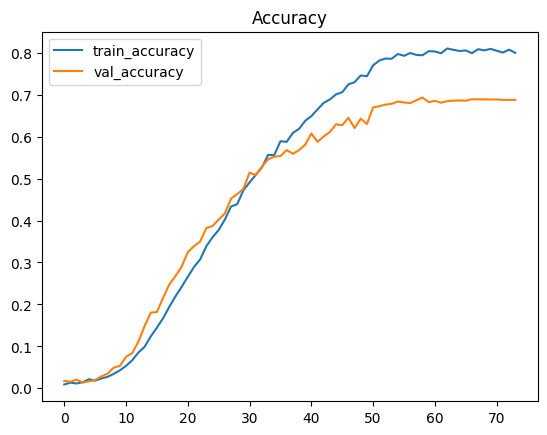

In [14]:
# Plot training history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()


In [15]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Chance level
print(f'Chance level: {1./num_classes*100:.1f}%')

92/92 [==============================] - 2s 17ms/step - loss: 1.6729 - accuracy: 0.6646
Test Loss: 1.6728860139846802
Test Accuracy: 0.6646133065223694
Chance level: 1.0%
